![](../logo.png)

# Gamma regression
## Yoav Ram

We will develop a new GLM model using the Gamma distribution. 

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
import statsmodels.api as sm

# Data: Palmer penguins

The [Palmer penguins dataset](http://dx.doi.org/10.32614/RJ-2022-020) includes body size measurements collected from 2007-2009 for three species of Pygoscelis penguins that breed on islands throughout the Palmer Archipelago, Antarctica.

We install a Python package, `palmerpenguins` and use it to load the dataset.

In [2]:
!pip install palmerpenguins

In [18]:
from palmerpenguins import load_penguins

In [19]:
df = load_penguins()
df = df.dropna(subset=['body_mass_g', 'bill_length_mm', 'bill_depth_mm', 'island'])
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


We one-hot encode the island variable using `pd.get_dummies`.

In [20]:
df = pd.get_dummies(df, columns=['island'], dtype=float)
df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,island_Biscoe,island_Dream,island_Torgersen
0,Adelie,39.1,18.7,181.0,3750.0,male,2007,0.0,0.0,1.0
1,Adelie,39.5,17.4,186.0,3800.0,female,2007,0.0,0.0,1.0
2,Adelie,40.3,18.0,195.0,3250.0,female,2007,0.0,0.0,1.0
4,Adelie,36.7,19.3,193.0,3450.0,female,2007,0.0,0.0,1.0
5,Adelie,39.3,20.6,190.0,3650.0,male,2007,0.0,0.0,1.0


# Gamma regression

We are going to use GLM to model the body mass as a function of island, bill length, and bill depth.

We will use the **Gamma distribution** (ProbML 2.7.5), which is suitable for modeling positive continous variables when the _variance increases with the mean (heteroskedaticity)_. In contrast, in normal linear regression the variance $\sigma$ is constant.

The Gamma distribution $$X \sim \text{Gamma}(a,s)$$ has parameters: shape $a$ and scale $s$, which define the mean, $\mathbb{E}[X]=a s$, and variance, $\mathbb{V}[X] = a s^2$.

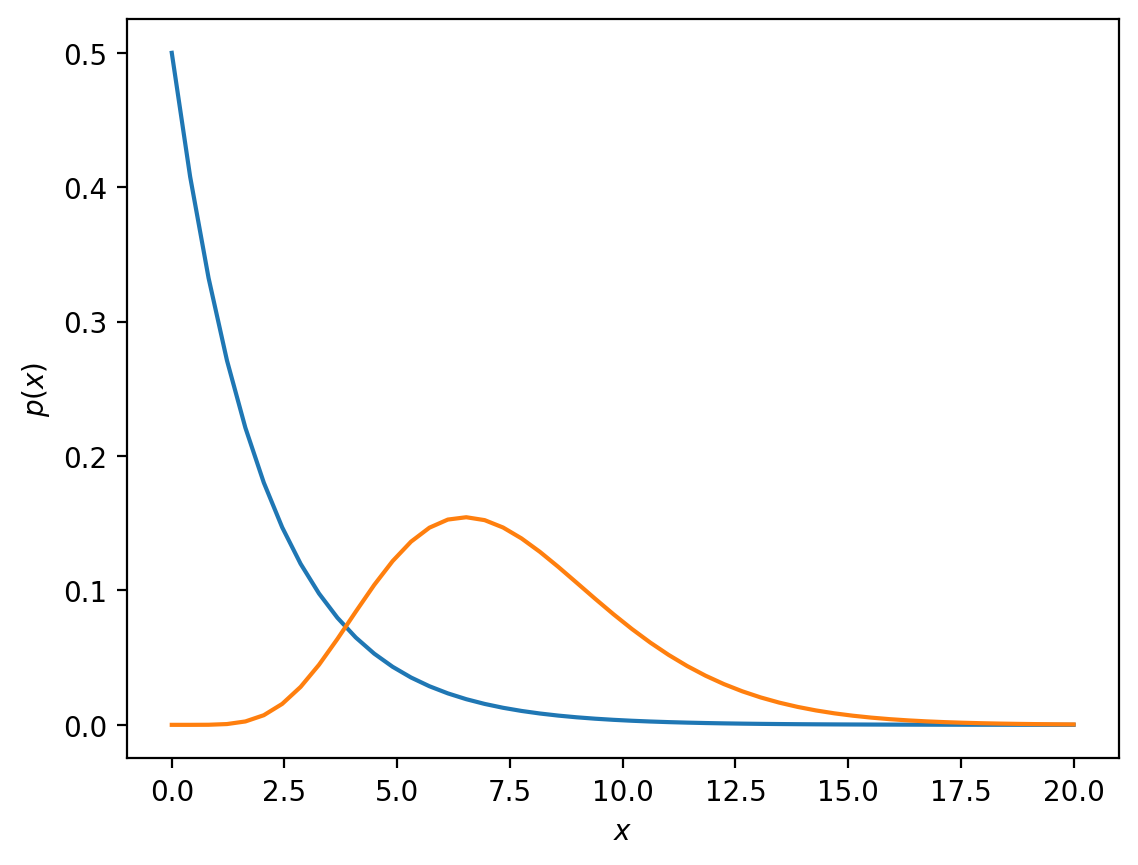

In [21]:
x_range = np.linspace(0, 20)
plt.plot(x_range, scipy.stats.gamma(1, scale=2).pdf(x_range))
plt.plot(x_range, scipy.stats.gamma(7.5, scale=1).pdf(x_range))
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

The model we are going to use is
$$
z_i = \sum_{j=1}^{m}{a_j \; x_{i,j}} + b $$$$
\hat{y}_i =  \log{z_i} $$$$
y_i \sim \text{Gamma}(\hat{y}_i/s, s)
$$
where $\hat{y}_i=as$ is the mean.

We grab the $X$ and $Y$, add a constant f or the intercept, and run the GLM from statsmodels.

In [38]:
X = df[['bill_length_mm', 'bill_depth_mm', 'island_Biscoe', 'island_Dream', 'island_Torgersen']]
Y = df['body_mass_g']
X = sm.add_constant(X)

In [39]:
model = sm.GLM(Y, X, family=sm.families.Gamma(link=sm.families.links.Log()))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            body_mass_g   No. Observations:                  342
Model:                            GLM   Df Residuals:                      337
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                        0.013568
Method:                          IRLS   Log-Likelihood:                -2596.5
Date:                Mon, 09 Dec 2024   Deviance:                       4.6086
Time:                        17:46:23   Pearson chi2:                     4.57
No. Iterations:                    10   Pseudo R-squ. (CS):             0.8030
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.6929      0.072     79.322      0.000       5.552       5.834
bill_length_mm       0.0177      0.001     13.986      0.000       0.015       0.020
bill_depth_mm       -0.0029      0.004     -0.701      0.483      -0.011       0.005
island_Biscoe        2.0030      0.023     88.308      0.000       1.959       2.047
island_Dream         1.8011      0.029     61.717      0.000       1.744       1.858
island_Torgersen     1.8888      0.028     68.667      0.000       1.835       1.943
====================================================================================
"""

The pseudo $R^2$ is high, 0.8. All variables are significant except for bill depth.

We can view the prediction error plot to see how good our model fit is.

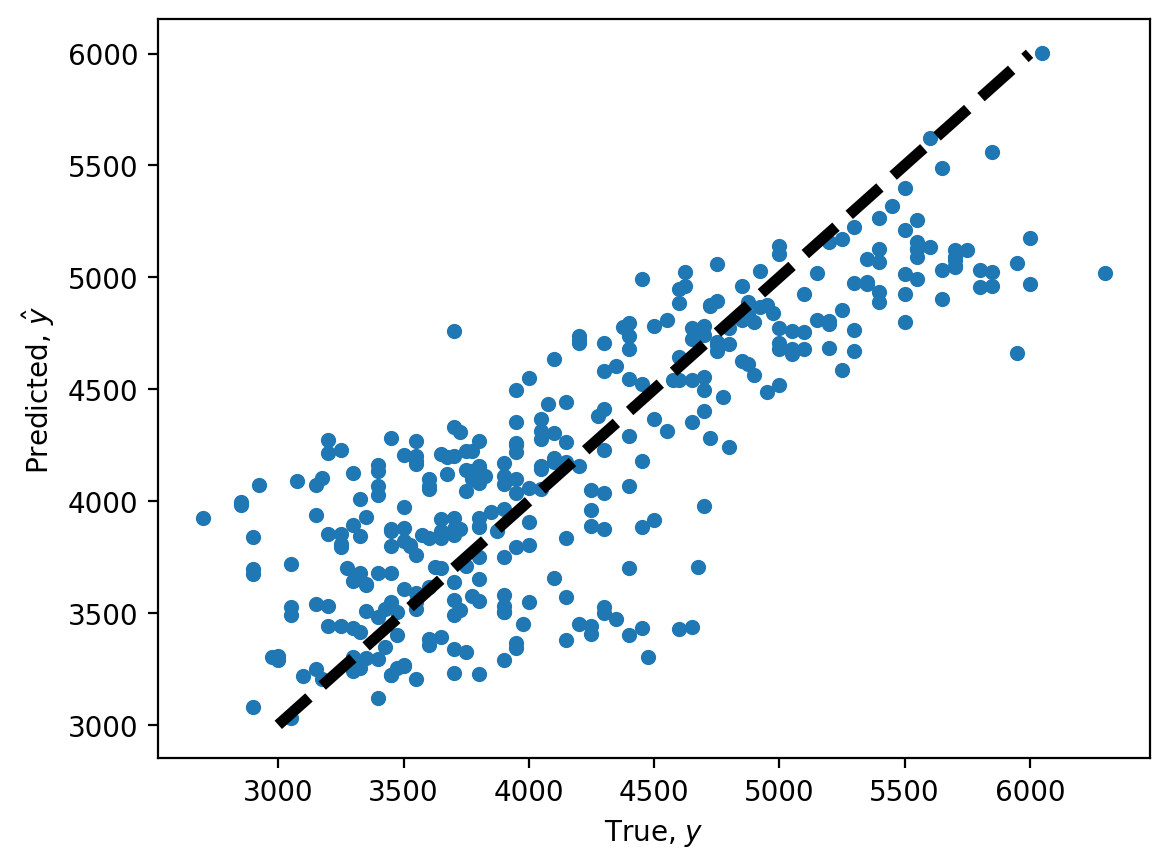

In [40]:
df['predicted_mass'] = result.predict(X)

df.plot.scatter('body_mass_g', 'predicted_mass')
plt.plot(np.arange(3000, 6000), np.arange(3000, 6000), '--k', lw=4)
plt.xlabel('True, $y$')
plt.ylabel(r'Predicted, $\hat{y}$');

# Exercise

Try to improve the fit by either removing or adding features.

# References

- [Scikit-learn Gamma regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.GammaRegressor.html)
- [Is Gamma regression really useful?](https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf) by Paul E. Johnson.
- - In All Likelihood by Yudi Pawitan, ch. 4.8; example 4.9.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)